In [1]:
import numpy as np
import os
import sys

from skimage.io import imread
from skimage.morphology import watershed

from time import time

from scipy import ndimage as ndi

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader

import PIL.Image as Image

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   

The code will run on GPU.


<h2> Nuclei dataset

Loading training set

In [3]:
train_path = "data/stage1_train"
list_dir = os.listdir(train_path)

images, masks = [], []
for folder in list_dir:
    with Image.open(os.path.join(train_path, folder, "images", folder + ".png")) as img:
        images.append(img.convert('RGB'))
    
    current_masks=[]
    for mask in os.listdir(os.path.join(train_path, folder, "masks")):
        with Image.open(os.path.join(train_path, folder, "masks", mask)) as mask_img:
            current_masks.append(mask_img.convert("L"))
    masks.append(current_masks)

In [4]:
class Nucleis_dataset(torch.utils.data.Dataset):
    def __init__(self, train, transform_image, transform_masks, images, masks):
        'Initialization'
        self.transform_image = transform_image
        self.transform_masks = transform_masks
        self.images = images
        self.masks  = masks

        
        self.idx = np.random.choice(len(self.images), len(self.images), replace=False)
        nb_train = int(.8 * len(self.images))
        tr, ts = np.split(self.idx, [nb_train])
        
        if train:
            self.images = [self.images[i] for i in tr]
            self.masks  = [self.masks[i] for i in tr]
        else:
            self.images = [self.images[i] for i in ts]
            self.masks  = [self.masks[i] for i in ts]
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.images)

    def __getitem__(self, idx):
        'Generates one sample of data'
        self.X = self.transform_image(self.images[idx])
    
        final_mask = torch.zeros([256, 256]).unsqueeze(0)
        for i, mask in enumerate(self.masks[idx]):
            transformed_mask = self.transform_masks(mask)
            transformed_mask[transformed_mask == 1] = i+1
            final_mask += transformed_mask
        return self.X, final_mask

<hr>

In [5]:
def iou(image_1, image_2):
    '''Function returning the IoU'''
    image_1_cpu = image_1.cpu()
    image_2_cpu = image_2.cpu()
    union = np.logical_or(image_1_cpu, image_2_cpu, dtype=np.float32) # assumed to non overlapped
    intersection = np.logical_and(image_1.cpu(), image_2.cpu(), dtype=np.float32)

    return torch.sum(intersection, dtype=torch.float32) / torch.sum(union, dtype=torch.float32)

In [33]:
def mAP(true_batch, pred_batch, batch_size, threshold=.7):
    # mapping output to predicted class
#     pred_batch = torch.sigmoid(pred_batch)
    sum_mAP = 0
    for (y_true, y_pred) in zip(true_batch, pred_batch):
        y_pred = y_pred.squeeze(0)
        sum_mAP += get_prediction_perf(y_true, y_pred, threshold)
        
    return sum_mAP / batch_size

In [41]:
def split_nucleis(image):
    '''Function that is splitting overlapping nucleis into different ones 
    using watershed segmentation'''
    image[image < 0.6] = 0

    markers = np.zeros_like(image)
    foreground, background = 2, 1
    markers[image <= .6] = background
    markers[image > .6] = foreground
    ws = watershed(image, markers)

    label_image, nb = ndi.label(ws - 1)

#     plt.figure()
#     plt.imshow(label_image)
    return torch.tensor(label_image)

In [42]:
def get_prediction_perf(mask_true, mask_pred, threshold):
    '''computing the tp, fp, fn for a given image'''
    mask_pred            = split_nucleis(mask_pred.detach().cpu().numpy()) # using watershed
    nb_nucleis           = int(torch.max(mask_true).item())
    nb_nucleis_predicted = int(torch.max(mask_pred).item())
    
    # creating a matrix where each row corresponds to a ground true nucleis,
    # each column to a predicted nucleis. M[i,j] is the IoU between ground truth
    # i and prediction j
    iou_matrix = np.zeros((nb_nucleis, nb_nucleis_predicted))
    for i in range(0, nb_nucleis):
        temp_mask = mask_true == i+1
        for j in range(0, nb_nucleis_predicted):
            iou_matrix[i][j] = iou(temp_mask, mask_pred == j+1)
    
    # getting the positives
    try:
        iou_max_predicted = np.max(iou_matrix, axis=1)
        tp = len(iou_max_predicted[iou_max_predicted > threshold])
        fp = len(iou_max_predicted[iou_max_predicted < threshold])
    except:
        tp, fp = 0, 0 # meaning there were no predicted mask

    # getting the negatives
    try:
        iou_max_expected  = np.max(iou_matrix, axis=0)
        fn = len(iou_max_expected[iou_max_expected < threshold])
    except:
        fn = 0 # meaning there were no mask
        

#     print("NUM: {} - DEN: {} - MAP: {}".format(tp, tp+fp+fn, tp / (tp+fp+fn+1)))
    return tp / (tp + fp + fn + 1)


In [9]:
def convert_mask_to_binary(Y_batch):
    Y_batch_copy = Y_batch.clone().detach() # copying Y_batch
    for i, elt in enumerate(Y_batch_copy):
        elt[elt > 0] = 1
        Y_batch_copy[i] = elt
    return Y_batch_copy

<h2> Network

In [63]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1)  # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(256)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(64*2, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(torch.cat([b, e3], 1))))
        d1 = F.relu(self.dec_conv1(self.upsample1(torch.cat([d0, e2], 1))))
        d2 = F.relu(self.dec_conv2(self.upsample2(torch.cat([e1, d1], 1))))
        d3 = self.dec_conv3(self.upsample3(torch.cat([e0,d2], 1))) # no activation
        return d3

In [11]:
def dice_loss(y_real, y_pred):
    y_pred = F.sigmoid(y_pred)
    num = torch.mean(2 * y_pred * y_real + 1) # adding 1 as a regularization term 
    den = torch.mean(y_real + y_pred + 1) # adding 1 as a regularization term 
    return 1 - (num / den)

In [12]:
def weighted_dice_loss(y_true, y_pred):
    # https://arxiv.org/pdf/1707.03237.pdf
    # https://www.kaggle.com/c/carvana-image-masking-challenge/discussion/37808
    y_pred = F.sigmoid(y_pred)

    mean = 0.15886614
    w_1 = 1 / mean**2
    w_0 = 1 /(1-mean)**2
    
    y_true_f_1 = torch.flatten(y_true)
    y_pred_f_1 = torch.flatten(y_pred)
    y_true_f_0 = torch.flatten(1-y_true)
    y_pred_f_0 = torch.flatten(1-y_pred)
    
    intersection_0 = torch.sum(y_true_f_0 * y_pred_f_0)
    intersection_1 = torch.sum(y_true_f_1 * y_pred_f_1)

    return 1 - (2 * (w_0 * intersection_0 + w_1 * intersection_1) / ((w_0 * (torch.sum(y_true_f_0) + torch.sum(y_pred_f_0))) + (w_1 * (torch.sum(y_true_f_1) + torch.sum(y_pred_f_1)))))

In [74]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    print(X_val.shape)
    batch_size   = X_val.shape[0]
    
    mAP_  = []
    loss_train = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # converting all masks to 1
            Y_batch_binary = convert_mask_to_binary(Y_batch) 
            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            
            loss = loss_fn(Y_batch_binary, Y_pred)
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(data_tr)
        loss_train.append(avg_loss)
        toc = time()
        print(' - loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = F.sigmoid(model(X_val.to(device))).detach().cpu()
        
        mAP_.append(mAP(Y_batch, Y_hat, batch_size))
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
#             plt.imshow(X_val[k].squeeze(0).numpy(), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return loss_train, mAP_

In [75]:
def evaluate(model, X_val, Y_val):
    model.eval()  # testing mode
    Y_pred = F.sigmoid(model(X_val.to(device))).detach().cpu()
    
    return Y_pred

In [76]:
batch_size = 10
size=(256,256)

transform_images_train = transforms.Compose([
    transforms.Resize(size),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([.5, .5, .5], [.5, .5, .5])
])

transform_images_test = transforms.Compose([
    transforms.Resize(size),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([.5, .5, .5], [.5, .5, .5])
])

transform_masks = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor()
])

train_set = Nucleis_dataset(True, transform_images_train, transform_masks, images, masks)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=3)

test_set = Nucleis_dataset(False, transform_images_test, transform_masks, images, masks)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=3)

In [77]:
model = UNet().to(device)

torch.Size([10, 3, 256, 256])
* Epoch 1/15
 - loss: 0.572030


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


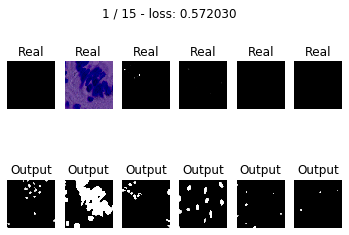

* Epoch 2/15
 - loss: 0.372328


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


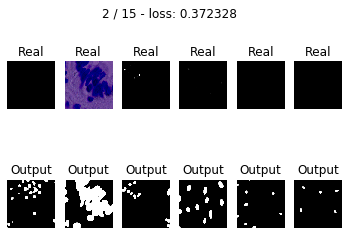

* Epoch 3/15
 - loss: 0.231239


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


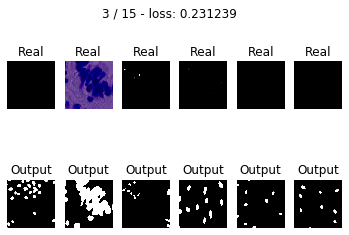

* Epoch 4/15
 - loss: 0.153522


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


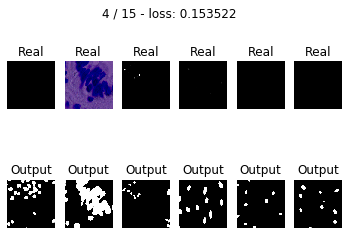

* Epoch 5/15
 - loss: 0.214904


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


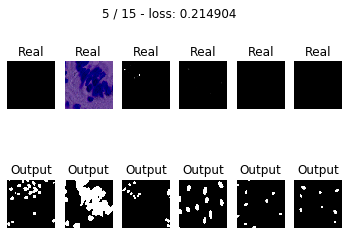

* Epoch 6/15
 - loss: 0.253247


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


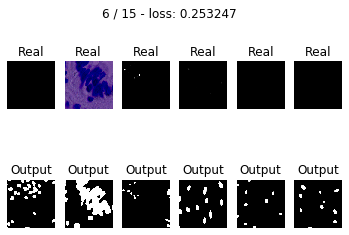

* Epoch 7/15
 - loss: 0.334690


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


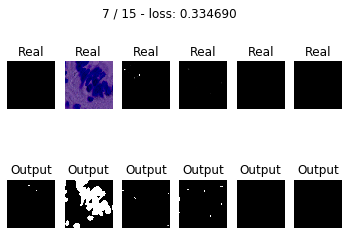

* Epoch 8/15
 - loss: 0.268974


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


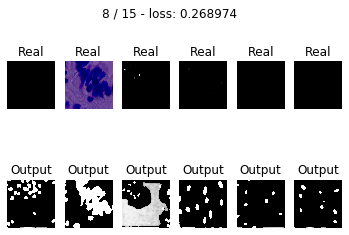

* Epoch 9/15
 - loss: 0.183310


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


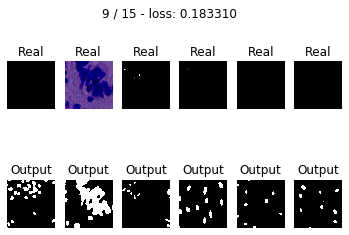

* Epoch 10/15
 - loss: 0.131743


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


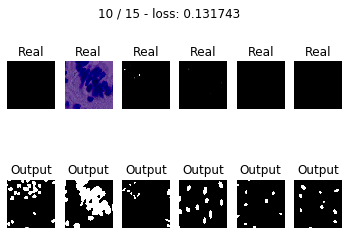

* Epoch 11/15
 - loss: 0.122121


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


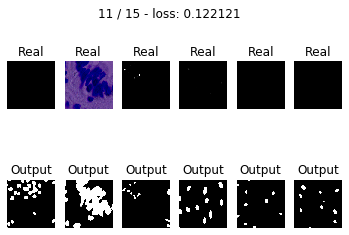

* Epoch 12/15
 - loss: 0.119255


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


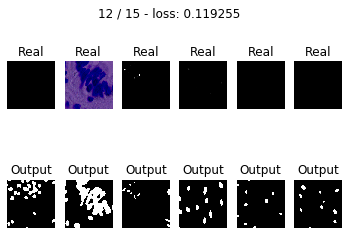

* Epoch 13/15
 - loss: 0.120084


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


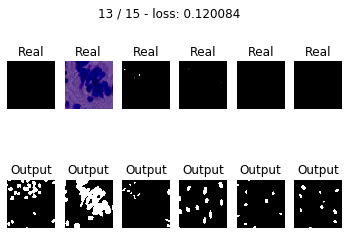

* Epoch 14/15
 - loss: 0.112476


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


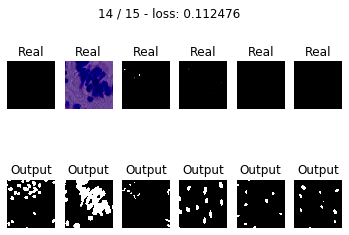

* Epoch 15/15
 - loss: 0.110793


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


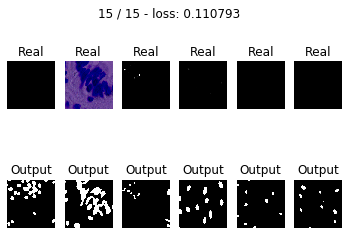

In [78]:
loss_train_gray_weighted_normalized, MAP_gray = train(model, optim.Adam(model.parameters(),lr=0.001), weighted_dice_loss, 15, train_loader, test_loader)

In [18]:
torch.save(model.state_dict(), "gray_scale_normalized_weighted.pth")

In [64]:
model = UNet()
model.to(device)
model.load_state_dict(torch.load("rgb_model.pth"));

In [65]:
images_batch, masks_batch = next(iter(test_loader))

In [66]:
y_pred = evaluate(model, images_batch, masks_batch)
masks_binary = convert_mask_to_binary(masks_batch)

/home/s182291/.conda/envs/py3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


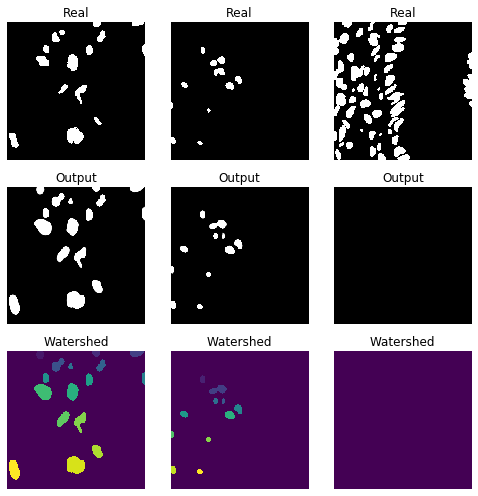

In [67]:
plt.figure(figsize=(7,7))
for k in range(3):
    plt.subplot(3, 3, k+1)
    plt.imshow(masks_binary[k].squeeze(0).numpy(), cmap='gray')
    plt.title('Real')
    plt.axis('off')

    plt.subplot(3, 3, k+4)
    plt.imshow(y_pred[k].squeeze(0).numpy(), cmap='gray')
    plt.title('Output')
    plt.axis('off')
    
    plt.subplot(3, 3, k+7)
    plt.imshow(split_nucleis(y_pred[k].squeeze(0).numpy()))
    plt.title("Watershed")
    plt.axis("off")
    
plt.tight_layout()
# plt.savefig("real_output_watershed.png")
plt.show()

In [79]:
threshold_list = [.4, .5, .6, .7, .8]
mAP_ = np.array([0., 0., 0., 0., 0.])
for i, (images_batch, masks_batch) in enumerate(test_loader):
    y_pred = evaluate(model, images_batch, masks_batch)
    for j, thresh in enumerate(threshold_list):
        mAP_[j] += mAP(masks_batch, y_pred, batch_size, threshold=thresh)

In [80]:
mAP_

array([6.83921231, 5.94457833, 5.09867053, 3.86268221, 1.83175496])

In [81]:
mAP_ / len(test_loader)

array([0.48851516, 0.42461274, 0.36419075, 0.27590587, 0.13083964])